<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/bias_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [1]:
import gensim.downloader as api
from gensim.matutils import cossim
from gensim.models import KeyedVectors
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load Files

**Annotations** contains crowdsourced annotations for response sentiment and relevance on source-response pairs obtained as described in the paper *RtGender: A Corpus for Studying Differential Responses to Gender* by Rob Voigt, David Jurgens, Vinodkumar Prabhakaran, Dan Jurafsky and Yulia Tsvetkov. Documentation is available [here](https://nlp.stanford.edu/robvoigt/rtgender/).

In [2]:
file_path_annotations = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/annotations.csv'
file_path_googlenews = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/word2vec-google-news-300.model'

In [3]:
dataframe_annotations = pd.read_csv(file_path_annotations)
dataframe_annotations.head()

,source,op_gender,post_text,response_text,sentiment,relevance
0,facebook_wiki,W,Stopped by Fashion Week and got to hang with A...,You are Both Sweet Ashley Tisdale and Lauren C...,Positive,Poster
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content
2,facebook_wiki,W,Tonight is going to be a good night #PerfectMo...,this is my city was there 2 weeks a go,Neutral,Content
3,facebook_wiki,M,I know grandma Gilmore is real proud of you ht...,if grizzly Adams had a beard.,Neutral,Content
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant


**Google News** contains a pre-trained Word2Vec model based on the Google News dataset, covering approximately 3 million words and phrases. Documentation is available [here](https://code.google.com/archive/p/word2vec/) and [here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py).

In [4]:
# model_googlenews = api.load('word2vec-google-news-300')
# model_googlenews.save(file_path_googlenews)

In [5]:
model_googlenews = KeyedVectors.load(file_path_googlenews, mmap='r')

In [6]:
for index, word in enumerate(model_googlenews.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_googlenews.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


In [7]:
model_googlenews.most_similar('she')

[('her', 0.7834683060646057),
 ('She', 0.7553189396858215),
 ('herself', 0.669890820980072),
 ('hers', 0.6509943008422852),
 ('he', 0.612994909286499),
 ('woman', 0.5641393661499023),
 ('Rivadineira', 0.558593213558197),
 ('Jana_Bobek', 0.5365386605262756),
 ('mother', 0.5349627137184143),
 ("she'sa", 0.5337814688682556)]

In [8]:
model_googlenews.most_similar('he')

[('He', 0.6712614297866821),
 ('him', 0.6681135892868042),
 ('his', 0.6201768517494202),
 ('she', 0.612994909286499),
 ('himself', 0.588027834892273),
 ('nobody', 0.5637064576148987),
 ('I', 0.555713951587677),
 ('it', 0.5354882478713989),
 ('never', 0.5239652395248413),
 ('somebody', 0.5205153822898865)]

In [66]:
model_googlenews.most_similar('woman')

[('man', 0.7664012908935547),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336829304695129),
 ('teenager', 0.6317085027694702),
 ('lady', 0.6288785934448242),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.6076306104660034),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975907444953918),
 ('Woman', 0.5770983099937439)]

In [67]:
model_googlenews.most_similar('man')

[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489763021469116)]

Nouns from v1.1 of the **HolisticBias** dataset, a project of the Responsible Natural Language Processing team at Facebook Research. The dataset is described in the paper **"I'm sorry to hear that": Finding New Biases in Language Models with a Holistic Descriptor Dataset** by Eric Michael Smith, Melissa Hall, Melanie Kambadur, Eleonora Presani, and Adina Williams. Documentation is available [here](https://github.com/facebookresearch/ResponsibleNLP/tree/main/holistic_bias/dataset/v1.1).

In [47]:
nouns = {
    "female": [
        ["woman", "women"],
        ["lady", "ladies"],
        ["gal", "gals"],
        ["girl", "girls"],
        ["mother", "mothers"],
        ["mom", "moms"],
        ["daughter", "daughters"],
        ["wife", "wives"],
        ["grandmother", "grandmothers"],
        ["grandma", "grandmas"],
        ["sister", "sisters"],
        # ["sista", "sistas"]
    ],
    "male": [
        ["man", "men"],
        ["bro", "bros"],
        ["guy", "guys"],
        ["boy", "boys"],
        ["father", "fathers"],
        ["dad", "dads"],
        ["son", "sons"],
        ["husband", "husbands"],
        ["grandfather", "grandfathers"],
        ["grandpa", "grandpas"],
        ["brother", "brothers"]
    ],
    "neutral": [
        ["individual", "individuals"],
        ["person", "people"],
        ["kid", "kids"],
        ["parent", "parents"],
        ["child", "children"],
        ["spouse", "spouses"],
        ["grandparent", "grandparents"],
        ["sibling", "siblings"],
        ["veteran", "veterans"]
    ]
}

In [48]:
female_nouns = [item for sublist in nouns['female'] for item in sublist]
male_nouns = [item for sublist in nouns['male'] for item in sublist]
neutral_nouns = [item for sublist in nouns['neutral'] for item in sublist]

**Pronouns** from Grammarly as described in the article *A Guide to Personal Pronouns and How They've Evolved*. The article includes additional neopronouns, pronouns that “refer to people entirely without reference to gender” (Grammarly, 2021). Documentation is available [here](https://www.grammarly.com/blog/gender-pronouns/).

In [49]:
pronouns = {
    "female": [
        "she",
        "her",
        "hers",
        "herself"
    ],
    "male": [
        "he",
        "him",
        "his",
        "himself"
    ],
    "neutral": [
        "they",
        "them",
        "theirs",
        "themself"
    ]
}

In [50]:
female_pronouns = pronouns['female']
male_pronouns = pronouns['male']
neutral_pronouns = pronouns['neutral']

In [55]:
female_nouns_pronouns = female_nouns + female_pronouns
male_nouns_pronouns = male_nouns + male_pronouns
neutral_nouns_pronouns = neutral_nouns + neutral_pronouns

## Tokenize Text

In developing a language model for English Tweets, Nguyen et al. (2020) used *TweetTokenizer* from the NLTK toolkit. *TweetTokenizer* preserves emojis and hashtags and attempts to normalize words with extra letters. Documentation is available [here](https://www.nltk.org/api/nltk.tokenize.casual.html).

In [12]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True, match_phone_numbers=False)

## Calculate Bias

Garg et al. (2018) use a different approach to assess the similarity between a set of neutral words and two groups, first subtracting the distance between each group and a neutral word, then summing the results across words. This approach gives equal weight to each word, unlike the approach below. Documentation is available [here](https://pubmed.ncbi.nlm.nih.gov/29615513/).

In [17]:
def add_bias(dataframe, text_column, male_tokens, female_tokens, tokenizer, model):
    """
    Calculate bias scores for text data in a DataFrame based on the difference in distances
    from male and female token embeddings.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing the text data.
    - text_column (str): Column name containing the text.
    - male_tokens (list of str): List of tokens associated with male attributes.
    - female_tokens (list of str): List of tokens associated with female attributes.
    - tokenizer: Tokenizer function to tokenize the text.
    - model: Model with a `get_mean_vector` method to compute embeddings.

    Returns:
    - pd.DataFrame: DataFrame with an additional 'bias' column.
    """
    # Drop rows with missing values in the text column and copy to avoid SettingWithCopyWarning
    dataframe = dataframe.dropna(subset=[text_column]).copy()

    # Compute embeddings and bias scores directly without intermediate columns
    male_vector = model.get_mean_vector(male_tokens)
    female_vector = model.get_mean_vector(female_tokens)

    def calculate_bias(text):
        tokens = tokenizer.tokenize(text)
        embedding = model.get_mean_vector(tokens)
        bias = np.linalg.norm(male_vector - embedding) - np.linalg.norm(female_vector - embedding)
        return bias

    # Apply the combined operation
    dataframe['bias'] = dataframe[text_column].apply(calculate_bias)

    return dataframe

The advantage of using cosine similarity is that the distance between vectors is normalized. However, because the number of male and female nouns in the HolisticBias dataset is similar, it may not be necessary to use a normalized measure, particularly if computational efficiency is compromised. Garg et al. (2018) use Euclidean distance.

## Explore Results

In the pre-trained Word2Vec model based on the Google News dataset, nouns are more similar to nouns and pronouns are more similar to pronouns. This could yield a difference in the bias calculation.

In [62]:
# Calculate bias using male and female nouns
dataframe_bias_nouns = add_bias(dataframe_annotations, 'response_text', male_nouns, female_nouns, tokenizer, model_googlenews)

In [64]:
# Calculate bias using male and female pronouns
dataframe_bias_pronouns = add_bias(dataframe_annotations, 'response_text', male_pronouns, female_pronouns, tokenizer, model_googlenews)

In [65]:
# Calculate bias using male and female nouns and pronouns
dataframe_bias_nouns_pronouns = add_bias(dataframe_annotations, 'response_text', male_nouns_pronouns, female_nouns_pronouns, tokenizer, model_googlenews)

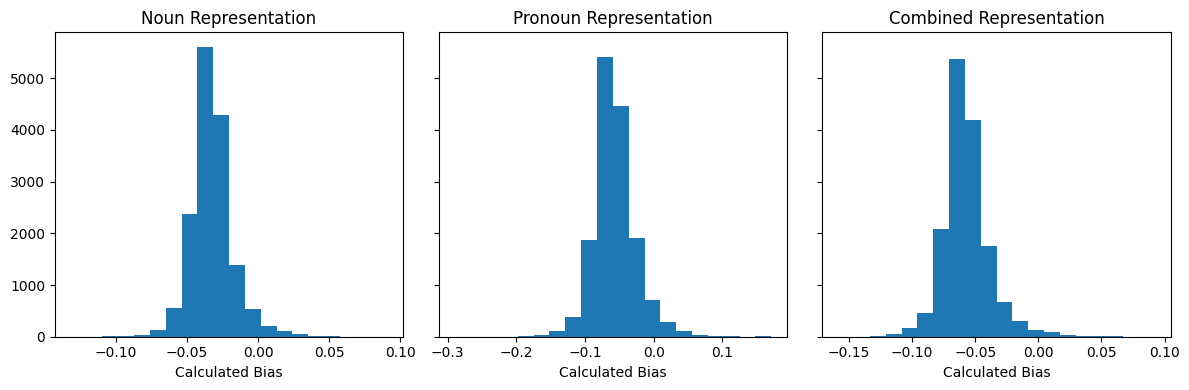

In [154]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True, tight_layout=True)

axs[0].hist(dataframe_bias_nouns['bias'], bins=20)
axs[1].hist(dataframe_bias_pronouns['bias'], bins=20)
axs[2].hist(dataframe_bias_nouns_pronouns['bias'], bins=20)

axs[0].set_title('Noun Representation')
axs[1].set_title('Pronoun Representation')
axs[2].set_title('Combined Representation')

for ax in axs:
  ax.set_xlabel('Calculated Bias')

fig.show()

There is more variance in the bias calculations based on pronouns than the bis calculations based on nouns, from roughly -0.20 to 0.10 for pronouns as compared to -0.10 to 0.05 for nouns. The combined representation is weighted toward nouns because there are more nouns in the HolisticBias dataset than there are pronouns.

### Compare Males

In [68]:
# Responses with the most male bias based on noun representation
dataframe_bias_nouns.sort_values('bias').head(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
1291,facebook_wiki,W,I love this story....so nice!,God Bless You Brother!,Positive,Irrelevant,-0.131889
1462,facebook_wiki,M,Some of my kidney stuff is on YouTube http://m...,God bless ya brother.,Positive,Content,-0.128856
8153,fitocracy,W,just joined the Fitocracy Team Fitness group!,"Yeeeah, buddy! Awesome stuff!",Positive,Content,-0.119475
7866,fitocracy,M,"Thanks for the follow, FB. Good luck with your...","Thanks, Brother. You too.",Positive,Poster,-0.115938
12471,reddit,W,"Reading the top comments in this thread, I jus...",He yelled allahu ackbar,Mixed,Content,-0.112012
5019,facebook_congress,M,"""The angel said to the women, ""Do not be afrai...",god bless cristian brother amen,Neutral,Irrelevant,-0.108247
357,facebook_wiki,W,Happy Father's Day to all the dads! Shaun Staf...,What a beautifull pic shaun brother with your ...,Positive,ContentPoster,-0.107964
741,facebook_wiki,W,Crazy lil ladies!!!!! Mis muecas :),Son mis hijas? Que bonitas.,Positive,Content,-0.107912
1831,facebook_wiki,W,Homeboy dumbfoundead fuckin killed that shit a...,Awkwafina's a Genius!!!!,Positive,Content,-0.103436
5517,facebook_congress,M,#TX23: Happy #FathersDay to my dad Bob Hurd. A...,Like Father like Son love both Mom,Positive,Content,-0.100355


In [70]:
# Responses with the most male bias based on pronoun representation
dataframe_bias_pronouns.sort_values('bias').head(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
12563,reddit,M,How does McConnell survive if this fails?,Hopefully he doesnt.,Negative,Content,-0.290068
12471,reddit,W,"Reading the top comments in this thread, I jus...",He yelled allahu ackbar,Mixed,Content,-0.266108
10681,reddit,M,The very definition of cuckservative.,put him in a cuckservation,Neutral,Content,-0.224731
10342,reddit,W,Lol...Happy birthday dude :) next time dont go...,"If he was capable of socialising , would he sp...",Negative,Poster,-0.216120
1007,facebook_wiki,M,More adventures with Craig!,Saw him last night. He was awesome!,Positive,Content,-0.210007
2639,facebook_wiki,M,#FindCraigFriday: He once visited the signing ...,Found him! https://www.facebook.com/photo.php?...,Neutral,Content,-0.208863
10136,reddit,W,What about lion? He killed a demon and ripped ...,And then he went back to hell than back,Neutral,Content,-0.194304
13593,ted,M,"Rory Stewart gave a talk about Foreign Policy,...","If you're a veteran listen to his ""talk"" find ...",Positive,Poster,-0.188937
2302,facebook_wiki,M,Timing is everything in life and politics. If ...,And he did just that!,Neutral,Content,-0.187213
7834,fitocracy,M,"what happened to you, man. You used to be cool.",agreed. and now i'm beating him...,Negative,ContentPoster,-0.186860


In [71]:
# Responses with the most male bias based on noun and pronoun representation
dataframe_bias_nouns_pronouns.sort_values('bias').head(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
12471,reddit,W,"Reading the top comments in this thread, I jus...",He yelled allahu ackbar,Mixed,Content,-0.158598
1291,facebook_wiki,W,I love this story....so nice!,God Bless You Brother!,Positive,Irrelevant,-0.155535
1462,facebook_wiki,M,Some of my kidney stuff is on YouTube http://m...,God bless ya brother.,Positive,Content,-0.149149
12563,reddit,M,How does McConnell survive if this fails?,Hopefully he doesnt.,Negative,Content,-0.147669
7866,fitocracy,M,"Thanks for the follow, FB. Good luck with your...","Thanks, Brother. You too.",Positive,Poster,-0.137996
10337,reddit,M,Just shot a coat of primer then he looked inside.,Him and my uncle tore that engine down.,Positive,Content,-0.137733
8153,fitocracy,W,just joined the Fitocracy Team Fitness group!,"Yeeeah, buddy! Awesome stuff!",Positive,Content,-0.136691
357,facebook_wiki,W,Happy Father's Day to all the dads! Shaun Staf...,What a beautifull pic shaun brother with your ...,Positive,ContentPoster,-0.134988
741,facebook_wiki,W,Crazy lil ladies!!!!! Mis muecas :),Son mis hijas? Que bonitas.,Positive,Content,-0.132343
1007,facebook_wiki,M,More adventures with Craig!,Saw him last night. He was awesome!,Positive,Content,-0.130260


### Compare Females

In [73]:
# Responses with the most female bias based on noun representation
dataframe_bias_nouns.sort_values('bias').tail(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
633,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Content,0.055713
3418,facebook_congress,W,Rep Fudge Featured on WomenAchieve.com,"Congratulations, Congresswoman Fudge!",Positive,Content,0.057561
3422,facebook_congress,W,Rep Fudge Featured on WomenAchieve.com,"Congratulations, Congresswoman Fudge!",Positive,Poster,0.057561
10077,reddit,M,There are a lot on youtube. I like this channel.,She is oddly milfalicious!,Positive,Irrelevant,0.062144
636,facebook_wiki,W,Ammetto che pi passano gli anni meno spirito N...,Tanti Auguri Jane,Neutral,Irrelevant,0.063824
14149,ted,W,"Julia Sweeney gave a talk about Christianity, ...","Julia is so adorable. Her intelligence, her st...",Positive,Content,0.078805
1156,facebook_wiki,W,Good luck to our Dan Ponce Sarah Jindra and Co...,Two beautiful women!!,Positive,ContentPoster,0.082767
146,facebook_wiki,W,Saw THE BUTLER. My ANTM cycle 3 alum Yaya does...,Shes a great actress!!!,Positive,Content,0.086396
12784,ted,W,"Julie Taymor gave a talk about creativity, ent...",Beautiful woman and beautiful story!,Positive,Content,0.086867
4536,facebook_congress,W,"Today, we mourn the passing of my dear friend ...",Beautiful and very talented lady/actress!,Positive,Poster,0.090833


In [74]:
# Responses with the most female bias based on pronoun representation
dataframe_bias_pronouns.sort_values('bias').tail(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
1660,facebook_wiki,M,A few months ago someone named Agnes Fred sent...,but she sings portuguese,Neutral,Content,0.124541
636,facebook_wiki,W,Ammetto che pi passano gli anni meno spirito N...,Tanti Auguri Jane,Neutral,Irrelevant,0.129042
347,facebook_wiki,W,10sballs.com is always in the know. Many thank...,magnifical beth.....,Mixed,Irrelevant,0.129446
1640,facebook_wiki,M,WWW.vincentmward.com,Betty white I love her,Positive,Irrelevant,0.138356
633,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Content,0.149659
1405,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Neutral,Irrelevant,0.149659
898,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Irrelevant,0.149659
12784,ted,W,"Julie Taymor gave a talk about creativity, ent...",Beautiful woman and beautiful story!,Positive,Content,0.152888
14149,ted,W,"Julia Sweeney gave a talk about Christianity, ...","Julia is so adorable. Her intelligence, her st...",Positive,Content,0.157864
146,facebook_wiki,W,Saw THE BUTLER. My ANTM cycle 3 alum Yaya does...,Shes a great actress!!!,Positive,Content,0.171164


In [75]:
# Responses with the most female bias based on noun and pronoun representation
dataframe_bias_nouns_pronouns.sort_values('bias').tail(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
10077,reddit,M,There are a lot on youtube. I like this channel.,She is oddly milfalicious!,Positive,Irrelevant,0.059771
1405,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Neutral,Irrelevant,0.061264
633,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Content,0.061264
898,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Irrelevant,0.061264
636,facebook_wiki,W,Ammetto che pi passano gli anni meno spirito N...,Tanti Auguri Jane,Neutral,Irrelevant,0.066340
1156,facebook_wiki,W,Good luck to our Dan Ponce Sarah Jindra and Co...,Two beautiful women!!,Positive,ContentPoster,0.078916
14149,ted,W,"Julia Sweeney gave a talk about Christianity, ...","Julia is so adorable. Her intelligence, her st...",Positive,Content,0.081869
4536,facebook_congress,W,"Today, we mourn the passing of my dear friend ...",Beautiful and very talented lady/actress!,Positive,Poster,0.086848
12784,ted,W,"Julie Taymor gave a talk about creativity, ent...",Beautiful woman and beautiful story!,Positive,Content,0.089885
146,facebook_wiki,W,Saw THE BUTLER. My ANTM cycle 3 alum Yaya does...,Shes a great actress!!!,Positive,Content,0.092399


### Compare Categories

bias    Axes(0.125,0.11;0.775x0.77)
dtype: object

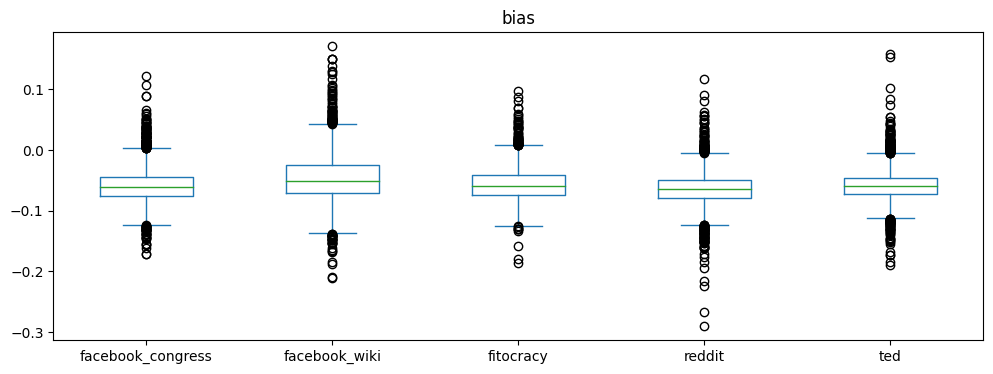

In [148]:
dataframe_bias_pronouns.plot.box('source', figsize=(12,4))

bias    Axes(0.125,0.11;0.775x0.77)
dtype: object

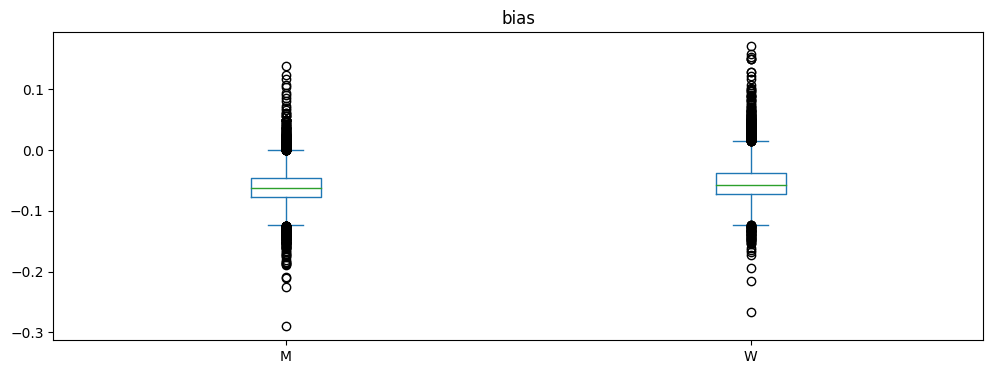

In [151]:
dataframe_bias_pronouns.plot.box('op_gender', figsize=(12,4))

bias    Axes(0.125,0.11;0.775x0.77)
dtype: object

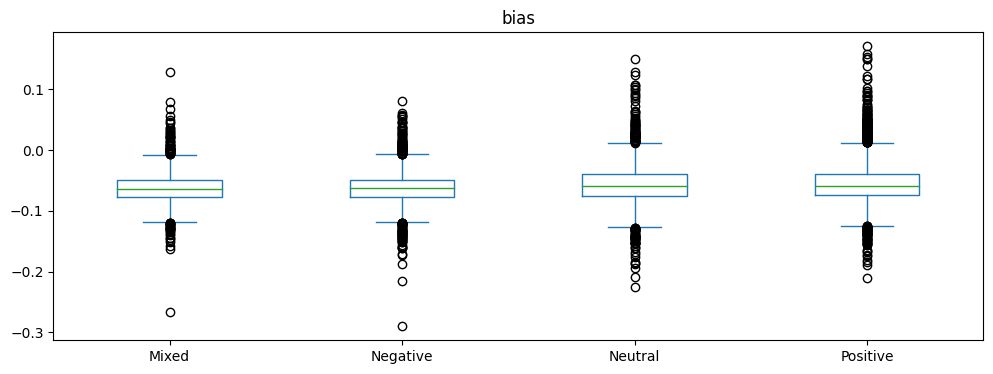

In [152]:
dataframe_bias_pronouns.plot.box('sentiment', figsize=(12,4))

bias    Axes(0.125,0.11;0.775x0.77)
dtype: object

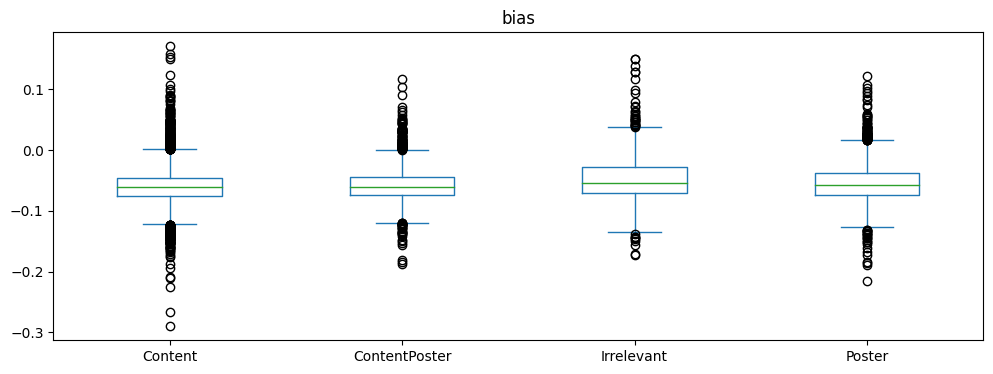

In [153]:
dataframe_bias_pronouns.plot.box('relevance', figsize=(12,4))

## References

"Please annotate the following code and convert it into PEP 8." OpenAI. (2023). ChatGPT (Jan 30 version) [Large language model]. https://chat.openai.com/chat

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. PNAS, 115(16). https://doi.org/10.1073/pnas.1720347115